In [1]:
import numpy as np
from config import Config
from reconstructor import Reconstructor

import matplotlib.pyplot as plt
import h5py
# from cuda import cuda, nvrtc

In [2]:
c = Config('ConfigFiles/RealG15.yml')
r = Reconstructor(c)


# Read the (x,y) Coordinates and I9 confidence

In [3]:
with h5py.File(c.micFile,'r') as f:
    GrainIDMap = f["GrainID"][:].astype(int)
    grid_x = f["Xcoordinate"][:]
    grid_y = f["Ycoordinate"][:]
    grid_c = f["Confidence"][:]

mask = np.where(GrainIDMap==c.grainID)
x = grid_x[mask]
y = grid_y[mask]
con = grid_c[mask]

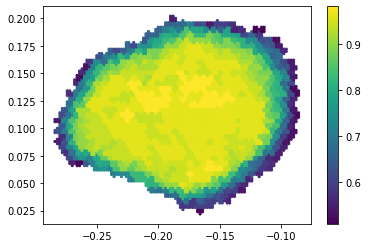

6266


In [4]:
threshold=0.5

fig, ax = plt.subplots()
cax=ax.scatter(x[con>threshold],y[con>threshold],c=con[con>threshold],s=5)
cbar = fig.colorbar(cax)

plt.show()

tmpx=x[con>threshold]
tmpy=y[con>threshold]

print(len(x[con>threshold]))

# Reconstruct strain tensor

In [5]:
Phase1_Conf, Phase1_S = r.ReconGridsPhase1(tmpx,tmpy,NumD=1000)

1.1097679138183594
0
4.844262361526489
1000
4.721150636672974
2000
4.695724964141846
3000
4.696957588195801
4000
4.64284348487854
5000
4.683670282363892
6000


In [6]:
# Phase1_S = np.load('cp_Phase1_S.npy')
r.SimPhase1Result(tmpx,tmpy,Phase1_S)


tmpS=Phase1_S.copy()
# tmpS = np.load('cp_Phase1_S.npy')
Phase2_S, history = r.ReconGridsPhase2(tmpx,tmpy,tmpS,iterN=10,NumD=1000)

1/10, loss=0
2/10, loss=-240734.23920726776
3/10, loss=-289397.4625425339
4/10, loss=-303073.7848446369
5/10, loss=-309418.18048232794
6/10, loss=-312448.5413840413
7/10, loss=-313884.67638784647
8/10, loss=-314925.4829309583
9/10, loss=-316831.2674089074
10/10, loss=-316719.1336732507


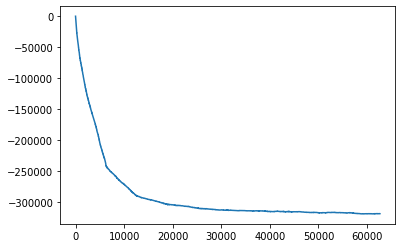

In [7]:
plt.plot(history)
plt.show()
np.save('pc_history',history)

In [8]:
# # change the nominal lattice parameters if it's needed 
# # when you think you used the wrong lattice parameter in the configure file, you can
# # modify the results like here without rerun the reconstruction
# MLatticeParam=np.diag([2.92539/2.95, 2.92539/2.95, 4.67399/4.7152])
# Phase2_S_corrected = np.einsum('ijk,kl->ijl',Phase2_S,MLatticeParam)

In [9]:
realO,realS = r.Transform2RealS(Phase2_S)

# with h5py.File(c.recFile, 'w') as f:
#     f.create_dataset("x", data=tmpx)
#     f.create_dataset("y", data=tmpy)

#     f.create_dataset("Phase1_Conf", data=Phase1_Conf)
#     f.create_dataset("Phase1_S", data=Phase1_S)

#     f.create_dataset("Phase2_S", data=Phase2_S)

#     f.create_dataset('Phase2_history', data=history)

#     f.create_dataset("realS", data=realS)
#     f.create_dataset("realO", data=realO)


# Visualizing the reconstruction results

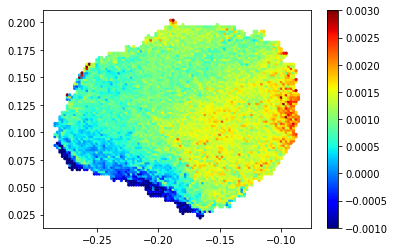

In [10]:
comp=[2,2]
fig, ax = plt.subplots()
cax=ax.scatter(tmpx,tmpy,c=realS[:,comp[0],comp[1]]-1,
               s=5,cmap='jet',
#                vmin=-0.0097,vmax=-0.0059
               vmin=-0.001,vmax=0.003
              )
cbar = fig.colorbar(cax)
# fig.savefig('Szz_1.png',format='png',dpi=300)
plt.show()

In [11]:
# # simulate the diffraction pattern from the reconstruction result
simulatedMaps=r.recon.simMap(tmpx,tmpy,Phase2_S,blur=False,dtype=np.uint32)

In [12]:
offset = np.where(r.peakFile['Imgs']['Im75'][:]==np.max(r.peakFile['Imgs']['Im75'][:]))[2][0]

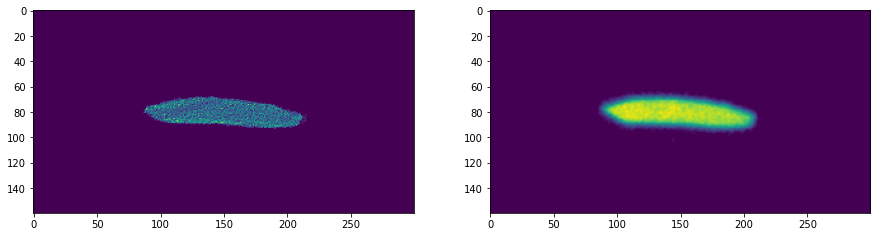

In [13]:
# # compare the simulated pattern with the real pattern

ii=75
# offset=ii
fig,axs=plt.subplots(1,2,figsize=(15,8))
axs[0].imshow(simulatedMaps[:,:,45*ii+offset])
axs[1].imshow(r.peakFile['Imgs']['Im{0:d}'.format(ii)][:,:,offset])
plt.show()

In [14]:
mean = np.eye(3)
cov = 1e-6 * np.eye(9)
NumD = 2000
S = np.empty((NumD, 3, 3), dtype=np.float32)
S[0, :, :] = mean
np.random.seed(42)
S[1:, :, :] = np.random.multivariate_normal(
    mean.ravel(), cov, size=(NumD - 1)).reshape((NumD - 1, 3, 3), order='C')

np.save('S',S)